# Erdio: Testing Classifiers

Testing audio classifiers for Project Erdio, an urban environmental sound classifier.

Team members (no particular order): Matthew Frick, Matthew Heffernan, Paul Jredini

Goal: Classify sounds for key stakeholders (see Stakeholder and KPI documentation).

In those notebook, I'll explore a variety of different classifiers, including Ensemble Learning, in the quest for an optimal classifier. I also investigate the power set to ensure we aren't throwing data at a wall and confusing ourselves.

### Remaining things to do:

- Tune the top candidates better and produce some plots

In [64]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

# Standard sklearn processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# sklearn Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.multioutput import ClassifierChain

## The VotingClassifier
from sklearn.ensemble import VotingClassifier
# The Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier

## import accuracy metric
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Define shortcuts for classifiers
names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "LDA",
    "ExtraTrees",
    "Boosted RF",
    "GradientBoosting"
]

# Collect classifiers into an iterable
## All the hyperparameters below can and should be investigated
scaled_classifiers = [
    make_pipeline(RobustScaler(), LogisticRegression(max_iter=5000)),
    make_pipeline(RobustScaler(), KNeighborsClassifier(5,n_jobs=4)),
    make_pipeline(RobustScaler(), SVC(kernel="linear", C=0.025)),
    make_pipeline(RobustScaler(), SVC(gamma=2, C=1)),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    make_pipeline(RobustScaler(), DecisionTreeClassifier(max_depth=15)),
    make_pipeline(RobustScaler(), RandomForestClassifier(max_depth=15, n_estimators=500,n_jobs=4)),
    make_pipeline(RobustScaler(), MLPClassifier(alpha=0.01, max_iter=1000,early_stopping=True)),
    make_pipeline(RobustScaler(), AdaBoostClassifier()),
    make_pipeline(RobustScaler(), GaussianNB()),
    make_pipeline(RobustScaler(), QuadraticDiscriminantAnalysis()),
    make_pipeline(RobustScaler(), LinearDiscriminantAnalysis()),
    make_pipeline(RobustScaler(), ExtraTreesClassifier(n_estimators=500, max_depth=15)),
    make_pipeline(RobustScaler(), AdaBoostClassifier(RandomForestClassifier(max_depth=15, n_estimators=500,n_jobs=4))),
    make_pipeline(RobustScaler(), GradientBoostingClassifier()),
]

classifiers = [
    LogisticRegression(max_iter=5000),
    KNeighborsClassifier(5,n_jobs=4),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=15),
    RandomForestClassifier(max_depth=15, n_estimators=500,n_jobs=4),
    MLPClassifier(alpha=0.01, max_iter=1000,early_stopping=True),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LinearDiscriminantAnalysis(),
    ExtraTreesClassifier(n_estimators=500, max_depth=15),
    AdaBoostClassifier(RandomForestClassifier(max_depth=15, n_estimators=500,n_jobs=4)),
    GradientBoostingClassifier(),
]

%matplotlib inline

## Setting up: Loading data, setting keys

In [177]:
# Keys for classifier 
#classify_keys = ['crestfactor','harmonic_power','percussive_power','percussive_hits','harmonic_hits']
# classify_keys = ['class', 'eq_0', 'eq_10', 'eq_20', 'eq_30', 'eq_40', 'eq_60', 'eq_80',
#        'eq_120', 'eq_160', 'eq_230', 'eq_300', 'eq_450', 'eq_600', 'eq_900',
#        'eq_1200', 'eq_1800', 'eq_2400', 'eq_3700', 'eq_5000', 'eq_7500',
#        'eq_10000', 'eq_15000', 'eq_20000', 'crestfactor', 'salience',
#        'harmonic_power', 'percussive_power', 'harmonic_hits',
#        'percussive_hits', 'power_ratio', 'hits_ratio'] 
classify_keys = [
 'eq_0',
 'eq_10',
 'eq_20',
 'eq_30',
 'eq_40',
 'eq_60',
 'eq_80',
 'eq_120',
 'eq_160',
 'eq_230',
 'eq_300',
 'eq_450',
 'eq_600',
 'eq_900',
 'eq_1200',
 'eq_1800',
 'eq_2400',
 'eq_3700',
 'eq_5000',
 'eq_7500',
 'eq_10000',
 'eq_15000',
 'eq_20000',
 'crestfactor',
 'salience',
 'harmonic_power',
 'percussive_power',
 'harmonic_hits',
 'percussive_hits',
 'power_ratio',
 'hits_ratio'
#  'roll_32.spec_flatness.median',
#  'roll_32.spec_flatness.iqr',
# #  'roll_32.spec_centroid.median',
#  'roll_32.spec_bandwidth.median',
#  'roll_32.spec_bandwidth.std',
#  'roll_32.y_mw_zcr',
#  'range_low.f0_signal',
#  'range_high.f0_stats.f0_mean',
#  'range_high.f0_stats.f0_median',
#  'range_high.f0_stats.f0_std',
#  'range_high.f0_stats.f0_iqr',
#  'range_high.f0_stats.f0_max',
#  'range_high.f0_stats.f0_min',
#  'range_high.f0_signal',
#  'range_low.f0_stats.f0_mean',
#  'range_low.f0_stats.f0_median',
#  'range_low.f0_stats.f0_std',
#  'range_low.f0_stats.f0_iqr',
#  'range_low.f0_stats.f0_max',
#  'range_low.f0_stats.f0_min'
                ]

In [149]:
eq_keys = [ 'eq_0',
 'eq_10',
 'eq_20',
 'eq_30',
 'eq_40',
 'eq_60',
 'eq_80',
 'eq_120',
 'eq_160',
 'eq_230',
 'eq_300',
 'eq_450',
 'eq_600',
 'eq_900',
 'eq_1200',
 'eq_1800',
 'eq_2400',
 'eq_3700',
 'eq_5000',
 'eq_7500',
 'eq_10000',
 'eq_15000',
 'eq_20000']

In [150]:
# Load data
#features_df = pd.read_csv('large_data/eq_with_harmony2.csv') # Old partial details
features_frick = pd.read_csv('large_data/eq_harmony_combined.csv') # From frick
#features = pd.read_csv('large_data/engineered_features_full1.csv', index_col=0) # From Paul
#features_f0 = pd.read_csv('large_data/engineered_features_f0_full1.csv', index_col=0) # From Paul
#features_df = pd.concat([features_frick, features, features_f0], axis=1)
#features_df.dropna() # Drops NaN rows from our feature processing list
features_df = features_frick
keys = list(features_df.keys())

In [151]:
keys

['class',
 'eq_0',
 'eq_10',
 'eq_20',
 'eq_30',
 'eq_40',
 'eq_60',
 'eq_80',
 'eq_120',
 'eq_160',
 'eq_230',
 'eq_300',
 'eq_450',
 'eq_600',
 'eq_900',
 'eq_1200',
 'eq_1800',
 'eq_2400',
 'eq_3700',
 'eq_5000',
 'eq_7500',
 'eq_10000',
 'eq_15000',
 'eq_20000',
 'crestfactor',
 'salience',
 'harmonic_power',
 'percussive_power',
 'harmonic_hits',
 'percussive_hits',
 'fold']

In [152]:
for eq in eq_keys:
    features_df[eq] = np.log10(features_df[eq])

In [153]:
features_df['power_ratio'] = np.log10(features_df['percussive_power'].values / (features_df['harmonic_power'].values))
features_df['hits_ratio'] = np.log10(features_df['percussive_hits'].values / (features_df['harmonic_hits'].values + 1e-1) + 5e-4)

In [154]:
keys

['class',
 'eq_0',
 'eq_10',
 'eq_20',
 'eq_30',
 'eq_40',
 'eq_60',
 'eq_80',
 'eq_120',
 'eq_160',
 'eq_230',
 'eq_300',
 'eq_450',
 'eq_600',
 'eq_900',
 'eq_1200',
 'eq_1800',
 'eq_2400',
 'eq_3700',
 'eq_5000',
 'eq_7500',
 'eq_10000',
 'eq_15000',
 'eq_20000',
 'crestfactor',
 'salience',
 'harmonic_power',
 'percussive_power',
 'harmonic_hits',
 'percussive_hits',
 'fold']

In [155]:
use_all = False # True # Use all features to predict
if use_all:
    classify_keys = keys[1:-1] # don't include class or fold

In [156]:
#classify_keys.remove('fold')

In [157]:
#classify_keys

In [158]:
features_df.describe()

,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,...,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold,power_ratio,hits_ratio
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,...,8732.000000,8732.000000,8732.000000,8.732000e+03,8.732000e+03,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,0.785337,0.892642,0.989648,1.060456,1.201832,1.287808,1.357483,1.389817,1.414340,1.419566,...,0.574723,8.104689,1.347000,2.360849e-03,2.970509e-04,216.039985,7.880898,5.385937,-0.995106,-1.640759
std,0.935234,0.925641,0.918903,0.900866,0.855738,0.815388,0.752803,0.719806,0.688163,0.662756,...,0.515552,5.137287,0.476043,1.339091e-02,1.818294e-03,245.710631,14.434843,2.846820,2.274398,1.034565
min,-3.364845,-3.267241,-3.225991,-3.199969,-2.976491,-2.968993,-2.963378,-2.782332,-2.558243,-2.361910,...,-1.832070,1.182664,1.000000,6.659914e-14,3.317685e-10,0.000000,0.000000,1.000000,-7.160499,-3.301030
25%,0.239100,0.353751,0.466158,0.559964,0.715394,0.827518,0.913237,0.963902,1.008940,1.032472,...,0.254031,5.116185,1.000000,4.304197e-06,6.014806e-07,43.454955,1.000000,3.000000,-2.398749,-2.303590
50%,0.837194,0.947724,1.051760,1.123707,1.302480,1.395580,1.470632,1.495065,1.535516,1.528382,...,0.622416,6.816937,1.000000,2.687486e-05,1.463032e-06,130.667553,3.000000,5.000000,-1.150139,-1.510981
75%,1.419438,1.536283,1.617141,1.673535,1.798016,1.878433,1.905592,1.911889,1.905981,1.900069,...,0.950792,9.666513,2.000000,2.986834e-04,1.168994e-05,293.975011,7.000000,8.000000,-0.037105,-0.946498
max,3.549806,3.336024,3.192284,3.135053,3.076486,3.004971,2.983684,3.013882,2.948173,2.928276,...,1.940247,99.133108,2.000000,6.049485e-01,4.137904e-02,2542.986702,86.000000,10.000000,10.470580,2.466889


In [159]:
features_df.head()

,class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,...,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold,power_ratio,hits_ratio
0,children_playing,0.772997,0.712426,0.713102,0.745311,0.702959,0.745459,0.761651,0.793981,0.699655,...,-0.257946,9.255638,1,0.000011,8.845374e-05,150.472464,4,5,0.889862,-1.567587
1,children_playing,-0.404583,-0.431886,-0.543574,-0.629743,-0.779261,-0.862212,-0.947772,-0.862379,-0.590296,...,0.557387,10.187929,1,0.002384,7.574148e-06,52.204787,2,10,-2.498050,-1.411869
2,street_music,0.599927,0.751218,0.927003,1.128319,1.288145,1.548013,1.791355,1.793211,1.843819,...,0.487044,7.897027,1,0.000030,6.712090e-05,332.313043,4,7,0.354830,-1.901937
3,engine_idling,1.692123,2.073951,2.616619,2.551652,2.474416,2.399168,2.272425,2.188971,2.090052,...,0.727442,2.837097,1,0.013045,2.409356e-07,132.342029,16,10,-4.733537,-0.916112
4,jackhammer,1.508975,1.808151,1.939758,1.977737,1.921932,1.896263,1.794886,1.753717,1.676690,...,0.589464,7.351516,1,0.000003,7.250180e-07,77.518617,64,1,-0.669574,-0.083523


In [160]:
features_df['salience'].describe()

count    8732.000000
mean        1.347000
std         0.476043
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: salience, dtype: float64

In [78]:
# What if we drop background sounds
#features_df = features_df[features_df['salience'] != 2]

In [161]:
# Try grouping sounds into families since jackhammers/drills are hard to differentiate between and 
# crowd noises drown out children playing and street music

#features_df['family'] = features_df['class'].replace({'air_conditioner':5, 'car_horn':1, 'children_playing':0, 'dog_bark':3, 'drilling':4, 'engine_idling':5, 'gun_shot':6, 'jackhammer':4, 'siren':8, 'street_music':0},inplace=False)

#features_df['family'] = features_df['class'].replace({'air_conditioner':0, 'car_horn':0, 'children_playing':0, 'dog_bark':0, 'drilling':0, 'engine_idling':0, 'gun_shot':1, 'jackhammer':0, 'siren':0, 'street_music':0},inplace=False)
features_df.replace({'air_conditioner':0, 'car_horn':1, 'children_playing':2, 'dog_bark':3, 'drilling':4,
                'engine_idling':5, 'gun_shot':6, 'jackhammer':7, 'siren':8, 'street_music':9},inplace=True)

In [162]:
# Searching for NaNs in input
np.where(np.isnan(features_df[classify_keys].values) == 1)

(array([], dtype=int64), array([], dtype=int64))

Now that we've loaded the data, I'll drop a fold as recommended by the documentation.

In [163]:
dropfold = 1

cv_features_df = features_df.drop(features_df[features_df['fold']==dropfold].index)
cv_features_df.drop(columns='fold',inplace=True)

validation_features_df = features_df.drop(features_df[features_df['fold']!=dropfold].index)
validation_features_df.drop(columns='fold',inplace=True)

In [164]:
cv_features_df.head()

,class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,...,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,power_ratio,hits_ratio
0,2,0.772997,0.712426,0.713102,0.745311,0.702959,0.745459,0.761651,0.793981,0.699655,...,-0.215696,-0.257946,9.255638,1,0.000011,8.845374e-05,150.472464,4,0.889862,-1.567587
1,2,-0.404583,-0.431886,-0.543574,-0.629743,-0.779261,-0.862212,-0.947772,-0.862379,-0.590296,...,0.636140,0.557387,10.187929,1,0.002384,7.574148e-06,52.204787,2,-2.498050,-1.411869
2,9,0.599927,0.751218,0.927003,1.128319,1.288145,1.548013,1.791355,1.793211,1.843819,...,0.528276,0.487044,7.897027,1,0.000030,6.712090e-05,332.313043,4,0.354830,-1.901937
3,5,1.692123,2.073951,2.616619,2.551652,2.474416,2.399168,2.272425,2.188971,2.090052,...,0.769349,0.727442,2.837097,1,0.013045,2.409356e-07,132.342029,16,-4.733537,-0.916112
5,5,0.946868,1.046500,1.016238,0.981577,1.004380,1.108758,1.334478,1.561918,1.548040,...,0.072507,-0.005021,3.722183,1,0.001770,3.998450e-07,1067.550532,0,-3.646108,-3.301030


In [165]:
cv_features_df.iloc[:,1:].values

array([[ 0.7729973 ,  0.71242643,  0.71310227, ...,  4.        ,
         0.88986188, -1.56758744],
       [-0.40458269, -0.43188613, -0.54357362, ...,  2.        ,
        -2.4980501 , -1.41186933],
       [ 0.59992689,  0.75121781,  0.92700271, ...,  4.        ,
         0.35482961, -1.90193726],
       ...,
       [ 0.06088342,  0.04968881,  0.07987968, ...,  5.        ,
        -1.73298128, -1.05687793],
       [ 0.83469809,  0.76121296,  0.79218785, ...,  3.        ,
        -0.85333115, -1.83396519],
       [-1.03094911, -1.03258675, -1.02254984, ...,  8.        ,
        -1.95872738, -0.94843748]])

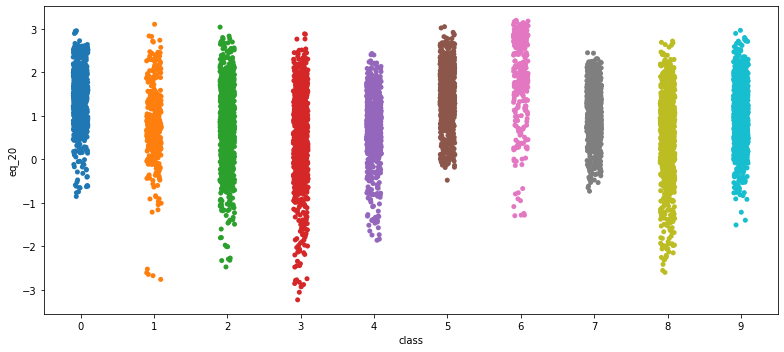

In [166]:
plt.figure(figsize=(11,5))
sns.stripplot(data = cv_features_df,
             x = 'class',
             y = 'eq_20')
plt.tight_layout()
plt.show()

In [167]:
def reduce_confmat(matrix):
    """
    Takes the N-dimensional confusion matrix as input and returns 
    a tuple (true positive, false positive, false negative) for the whole set.
    
    confusion matrix C is such that C_ij is equal to the 
    number of observations known to be in group i 
    and predicted to be in group j.
    """
    
    tps = [] # True positives for each axis
    fps = [] # True 
    fns = []
    
    for i in range(len(matrix)):
        
        tps.append(matrix[i,i]) # Append true positives for a class
        #confusion_matrix(pred,y_test)[0,:] # returns row 0
        #confusion_matrix(pred,y_test)[:,0] # returns column 0
        fps.append( np.delete(matrix[:,i],i).sum() ) # take sum, dropping the diagonal element
        fns.append( np.delete(matrix[i,:],i).sum() ) # take sum, dropping the diagonal element
        
    res = (tps, fps, fns)
    return res

In [168]:
def TPR(prediction, data):
    """
    Returns True Positive Ratio given a prediction and data
    """
    confmat = confusion_matrix(prediction, data)
#     print(confmat)
#     plt.figure()
#     ConfusionMatrixDisplay(confmat)
#     plt.show()
#     TN = confmat[0,0]
#     FP = confmat[0,1]
#     FN = confmat[1,0]
#     TP = confmat[1,1]
    
    (TP, FP, FN) = reduce_confmat(confmat)
    
    truepos = lambda a, b, c: a/(b+c)
    
    return [truepos(TP[i], TP[i], FN[i]) for i in range(len(TP))]
    

    

In [169]:
def recall(prediction, data):
    """
    Calculates recall of a prediction
    """
    
    confmat = confusion_matrix(prediction, data)

#     TN = confmat[0,0]
#     FP = confmat[0,1]
#     FN = confmat[1,0]
#     TP = confmat[1,1]
    (TP, FP, FN) = reduce_confmat(confmat)
    
    rec = lambda a, b, c: a/(b+c)
    
    return [rec(TP[i], TP[i], FN[i]) for i in range(len(TP))]
    

def precision(prediction, data):
    """
    Calculates precision of a prediction
    """
    
    confmat = confusion_matrix(prediction, data)

#     TN = confmat[0,0]
#     FP = confmat[0,1]
#     FN = confmat[1,0]
#     TP = confmat[1,1]
    (TP, FP, FN) = reduce_confmat(confmat)
    
    prec = lambda a, b, c: a/(b+c)
    
    return [prec(TP[i], TP[i], FP[i]) for i in range(len(TP))]
    

In [170]:
def Fmeasure(prediction, data):
    """
    Returns Fmeasure. 
    
    This is considered a balance of the precision and the recall.
    
    F = (2*P*R)/(P+R)
    
    where
    
    P = TP/(TP + FP) is the precision and
    R = TP/(TP + FN) is the recall.
    
    Reference: 
    Müller, Meinard. Fundamentals of music processing: Audio, analysis, algorithms, applications. 
    Vol. 5. Cham: Springer, 2015.
    Sec. 4.5 pp. 217
    """
    confmat = confusion_matrix(prediction, data)

#     TN = confmat[0,0]
#     FP = confmat[0,1]
#     FN = confmat[1,0]
#     TP = confmat[1,1]
    
    (TP, FP, FN) = reduce_confmat(confmat)
    
#     P = TP/(TP + FP)
#     R = TP/(TP + FN)
    
    workhorse = lambda a, b, c: a/(b+c)
    Fmeas = lambda x,y : (2*x*y)/(x+y)
    
    P = [workhorse(TP[i], TP[i], FP[i]) for i in range(len(TP))]
    R = [workhorse(TP[i], TP[i], FN[i]) for i in range(len(TP))]
    
    
    #F = (2*P*R)/(P + R)
    return [Fmeas(P[i],R[i]) for i in range(len(P))] #F
    

## Establishing a baseline: The Random Forest

In [171]:
if len(classify_keys) == 1:
    X_train = cv_features_df[classify_keys[0]].values.reshape(-1,1)
else:
    X_train = cv_features_df.iloc[:,1:-1].values # same as using all keys?#cv_features_df[classify_keys].values
    
y_train = cv_features_df['class'].values

X_test = validation_features_df.iloc[:,1:-1].values #[classify_keys].values
y_test = validation_features_df['class']

In [172]:
cv_features_df.head()

,class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,...,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,power_ratio,hits_ratio
0,2,0.772997,0.712426,0.713102,0.745311,0.702959,0.745459,0.761651,0.793981,0.699655,...,-0.215696,-0.257946,9.255638,1,0.000011,8.845374e-05,150.472464,4,0.889862,-1.567587
1,2,-0.404583,-0.431886,-0.543574,-0.629743,-0.779261,-0.862212,-0.947772,-0.862379,-0.590296,...,0.636140,0.557387,10.187929,1,0.002384,7.574148e-06,52.204787,2,-2.498050,-1.411869
2,9,0.599927,0.751218,0.927003,1.128319,1.288145,1.548013,1.791355,1.793211,1.843819,...,0.528276,0.487044,7.897027,1,0.000030,6.712090e-05,332.313043,4,0.354830,-1.901937
3,5,1.692123,2.073951,2.616619,2.551652,2.474416,2.399168,2.272425,2.188971,2.090052,...,0.769349,0.727442,2.837097,1,0.013045,2.409356e-07,132.342029,16,-4.733537,-0.916112
5,5,0.946868,1.046500,1.016238,0.981577,1.004380,1.108758,1.334478,1.561918,1.548040,...,0.072507,-0.005021,3.722183,1,0.001770,3.998450e-07,1067.550532,0,-3.646108,-3.301030


In [180]:
cv_features_df.keys()

Index(['class', 'eq_0', 'eq_10', 'eq_20', 'eq_30', 'eq_40', 'eq_60', 'eq_80',
       'eq_120', 'eq_160', 'eq_230', 'eq_300', 'eq_450', 'eq_600', 'eq_900',
       'eq_1200', 'eq_1800', 'eq_2400', 'eq_3700', 'eq_5000', 'eq_7500',
       'eq_10000', 'eq_15000', 'eq_20000', 'crestfactor', 'salience',
       'harmonic_power', 'percussive_power', 'harmonic_hits',
       'percussive_hits', 'power_ratio', 'hits_ratio'],
      dtype='object')

In [181]:
cv_features_df.iloc[:,1:].values[0]

array([ 7.72997302e-01,  7.12426429e-01,  7.13102268e-01,  7.45311465e-01,
        7.02959424e-01,  7.45458926e-01,  7.61651224e-01,  7.93981288e-01,
        6.99654896e-01,  6.37195772e-01,  5.73170225e-01,  6.46992554e-01,
        5.70205174e-01,  5.27032948e-01,  4.49930811e-01,  4.63852727e-01,
        3.92856282e-01,  3.37290674e-01,  1.82557382e-01,  6.92414907e-02,
       -9.21990706e-02, -2.15696264e-01, -2.57945840e-01,  9.25563849e+00,
        1.00000000e+00,  1.13986741e-05,  8.84537444e-05,  1.50472464e+02,
        4.00000000e+00,  8.89861884e-01, -1.56758744e+00])

In [182]:
cv_features_df[classify_keys].values[0]

array([ 7.72997302e-01,  7.12426429e-01,  7.13102268e-01,  7.45311465e-01,
        7.02959424e-01,  7.45458926e-01,  7.61651224e-01,  7.93981288e-01,
        6.99654896e-01,  6.37195772e-01,  5.73170225e-01,  6.46992554e-01,
        5.70205174e-01,  5.27032948e-01,  4.49930811e-01,  4.63852727e-01,
        3.92856282e-01,  3.37290674e-01,  1.82557382e-01,  6.92414907e-02,
       -9.21990706e-02, -2.15696264e-01, -2.57945840e-01,  9.25563849e+00,
        1.00000000e+00,  1.13986741e-05,  8.84537444e-05,  1.50472464e+02,
        4.00000000e+00,  8.89861884e-01, -1.56758744e+00])

In [183]:
set(np.where(np.isnan(X_train) == 1)[0])

set()

In [184]:
#forest = make_pipeline(RobustScaler(), RandomForestClassifier(max_depth=len(set(features_df['class'])), n_estimators=1000,n_jobs=4))
forest = RandomForestClassifier(max_depth=len(set(features_df['class'])), n_estimators=1000,n_jobs=4)

In [185]:
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=4)

In [186]:
pred = forest.predict(X_test)

In [187]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.21      0.36      0.26        59
           1       0.31      0.79      0.44        14
           2       0.52      0.39      0.45       132
           3       0.66      0.82      0.73        80
           4       0.71      0.40      0.51       178
           5       0.39      0.51      0.44        72
           6       0.43      0.52      0.47        29
           7       0.53      0.67      0.59        96
           8       0.70      0.78      0.74        77
           9       0.58      0.43      0.49       136

    accuracy                           0.52       873
   macro avg       0.50      0.57      0.51       873
weighted avg       0.56      0.52      0.52       873



In [188]:
accuracy_score(pred,y_test)

0.5211912943871707

In [189]:
classlabels = {'air_conditioner':0, 'car_horn':1, 'children_playing':2, 'dog_bark':3, 'drilling':4, 'engine_idling':5, 'gun_shot':6, 'jackhammer':7, 'siren':8, 'street_music':9}.keys()
#classlabels = {'air_conditioner':0, 'car_horn':1, 'dog_bark':3, 'drilling':4, 'engine_idling':5, 'gun_shot':6, 'jackhammer':7, 'siren':8, 'street_music':9}.keys()


#familylabels = {'house_sounds':0, 'car_horn':1, 'dog_bark':3, 'drilling':4, 'engine_idling':5, 'gun_shot':6, 'jackhammer':7, 'siren':8, }.keys()

#familylabels = {'house_sounds':0, 'car_horn':1, 'dog_bark':3, 'construction':4, 'motors':5, 'gun_shot':6, 'siren':8}.keys()
familylabels = {'not gunshot':0, 'gunshot':1}.keys()

In [190]:
TPR(pred,y_test)

[0.3559322033898305,
 0.7857142857142857,
 0.3939393939393939,
 0.825,
 0.398876404494382,
 0.5138888888888888,
 0.5172413793103449,
 0.6666666666666666,
 0.7792207792207793,
 0.4264705882352941]

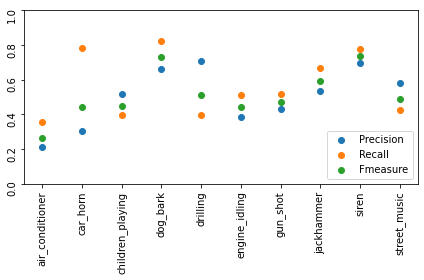

In [191]:
fig = plt.figure()
ax0 = fig.add_subplot(111)

#ax0.scatter(classlabels,TPR(pred,y_test),label='TPR')
ax0.scatter(classlabels,precision(pred,y_test),label='Precision')
ax0.scatter(classlabels,recall(pred,y_test),label='Recall')
ax0.scatter(classlabels,Fmeasure(pred,y_test),label='Fmeasure')

ax0.tick_params(rotation=90)
ax0.legend()
ax0.set_ylim(0,1)

plt.tight_layout()
plt.show()

TypeError: list indices must be integers or slices, not str

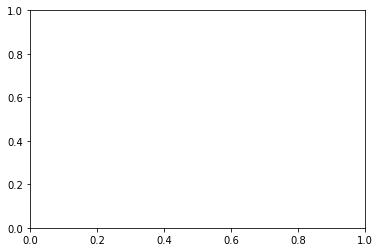

In [192]:
fig = plt.figure()
ax0 = fig.add_subplot(111)

ax0.bar(classify_keys,forest['randomforestclassifier'].feature_importances_)

ax0.tick_params(rotation=90)
ax0.set_ylabel('Feature importance')

plt.tight_layout()
plt.show()

In [193]:
confusion_matrix(pred,y_test)

array([[21,  2,  5,  2,  2, 19,  0,  0,  5,  3],
       [ 0, 11,  0,  1,  2,  0,  0,  0,  0,  0],
       [ 6,  4, 52, 18, 13,  1, 13,  0, 11, 14],
       [ 0,  1,  7, 66,  2,  0,  1,  0,  3,  0],
       [ 1,  3,  5,  3, 71, 28,  6, 48,  2, 11],
       [ 9,  3,  6,  3,  5, 37,  0,  6,  0,  3],
       [ 3,  0,  3,  2,  0,  0, 15,  1,  5,  0],
       [16,  0,  0,  0,  1,  8,  0, 64,  0,  7],
       [ 0,  2,  7,  2,  2,  0,  0,  0, 60,  4],
       [44, 10, 15,  3,  2,  3,  0,  1,  0, 58]])

<Figure size 648x648 with 0 Axes>

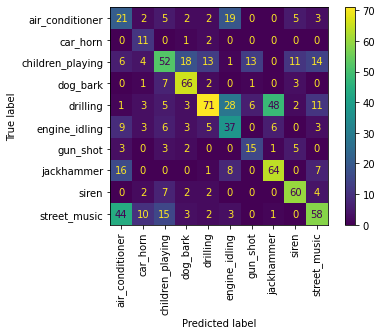

In [194]:
plt.figure(figsize=(9,9))
disp = ConfusionMatrixDisplay(confusion_matrix(pred,y_test),display_labels=classlabels)
disp.plot(xticks_rotation='vertical')
plt.show()

### Trying another model: A simple NN

In [230]:
mlp = make_pipeline(MLPClassifier(hidden_layer_sizes=(150,150,150,150,150,), max_iter=100000,early_stopping=True))
# MLPClassifier(max_iter=10000,early_stopping=True,learning_rate='adaptive')

In [231]:
mlp.fit(X_train, y_train)

Pipeline(steps=[('mlpclassifier',
                 MLPClassifier(early_stopping=True,
                               hidden_layer_sizes=(150, 150, 150, 150, 150),
                               max_iter=100000))])

In [232]:
pred_mlp = mlp.predict(X_test)

In [233]:
accuracy_score(pred_mlp,y_test)

0.5807560137457045

In [234]:
TPR(pred_mlp,y_test)

[0.6063829787234043,
 0.48148148148148145,
 0.5116279069767442,
 0.6987951807228916,
 0.4125874125874126,
 0.49019607843137253,
 0.5660377358490566,
 0.945054945054945,
 0.759493670886076,
 0.43478260869565216]

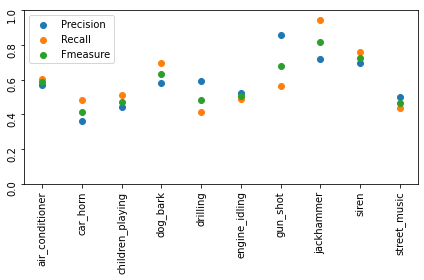

In [235]:
fig = plt.figure()
ax0 = fig.add_subplot(111)

#ax0.scatter(classlabels,TPR(pred,y_test),label='TPR')
ax0.scatter(classlabels,precision(pred_mlp,y_test),label='Precision')
ax0.scatter(classlabels,recall(pred_mlp,y_test),label='Recall')
ax0.scatter(classlabels,Fmeasure(pred_mlp,y_test),label='Fmeasure')

ax0.tick_params(rotation=90)
ax0.legend()
ax0.set_ylim(0,1)

plt.tight_layout()
plt.show()

## And now a more involved NN using Keras

In [375]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 
from tensorflow.keras.metrics import CategoricalAccuracy, Recall

In [380]:
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=len(classify_keys)-1))
model.add(Dense(350, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(150, activation='relu'))
#model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='rmsprop', # was: adam
              loss='categorical_crossentropy', 
              metrics=[Recall(),CategoricalAccuracy()])

In [381]:
X_train.shape

(7859, 30)

In [382]:
n_epochs = 50
history = model.fit(X_train, to_categorical(y_train), epochs=n_epochs, verbose = 1,
              validation_data = (X_test, to_categorical(y_test)))

Epoch 1/50
246/246 [==============================] - 2s 5ms/step - loss: 2.5790 - recall_1: 0.1132 - categorical_accuracy: 0.2723 - val_loss: 1.6496 - val_recall_1: 0.2314 - val_categorical_accuracy: 0.3723
Epoch 2/50
246/246 [==============================] - 1s 4ms/step - loss: 1.7768 - recall_1: 0.1672 - categorical_accuracy: 0.3644 - val_loss: 1.4888 - val_recall_1: 0.2520 - val_categorical_accuracy: 0.4926
Epoch 3/50
246/246 [==============================] - 1s 4ms/step - loss: 1.6138 - recall_1: 0.2145 - categorical_accuracy: 0.4153 - val_loss: 1.4970 - val_recall_1: 0.2910 - val_categorical_accuracy: 0.4456
Epoch 4/50
246/246 [==============================] - 1s 4ms/step - loss: 1.4769 - recall_1: 0.2792 - categorical_accuracy: 0.4742 - val_loss: 1.3827 - val_recall_1: 0.3001 - val_categorical_accuracy: 0.4880
Epoch 5/50
246/246 [==============================] - 1s 4ms/step - loss: 1.3747 - recall_1: 0.3199 - categorical_accuracy: 0.4980 - val_loss: 1.4568 - val_recall_1: 0.

246/246 [==============================] - 1s 4ms/step - loss: 0.8056 - recall_1: 0.6497 - categorical_accuracy: 0.7327 - val_loss: 3.5096 - val_recall_1: 0.4055 - val_categorical_accuracy: 0.4593
Epoch 41/50
246/246 [==============================] - 1s 4ms/step - loss: 0.8045 - recall_1: 0.6540 - categorical_accuracy: 0.7348 - val_loss: 2.6050 - val_recall_1: 0.4822 - val_categorical_accuracy: 0.5475
Epoch 42/50
246/246 [==============================] - 1s 4ms/step - loss: 0.7897 - recall_1: 0.6501 - categorical_accuracy: 0.7353 - val_loss: 2.8635 - val_recall_1: 0.4651 - val_categorical_accuracy: 0.5407
Epoch 43/50
246/246 [==============================] - 1s 4ms/step - loss: 0.8079 - recall_1: 0.6515 - categorical_accuracy: 0.7370 - val_loss: 3.1033 - val_recall_1: 0.4387 - val_categorical_accuracy: 0.5040
Epoch 44/50
246/246 [==============================] - 1s 4ms/step - loss: 0.7503 - recall_1: 0.6710 - categorical_accuracy: 0.7448 - val_loss: 3.5638 - val_recall_1: 0.4777 - 

In [383]:
pred_train= model.predict(X_train)
scores = model.evaluate(X_train, to_categorical(y_train), verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, to_categorical(y_test), verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

246/246 [==============================] - 0s 2ms/step
Accuracy on training data: 0.6350680589675903% 
 Error on training data: 0.36493194103240967
28/28 [==============================] - 0s 2ms/step
Accuracy on test data: 0.4822451174259186% 
 Error on test data: 0.5177548825740814


In [384]:
keras_confmat = confusion_matrix(to_categorical(y_test).argmax(axis=1), pred_test.argmax(axis=1))

<Figure size 648x648 with 0 Axes>

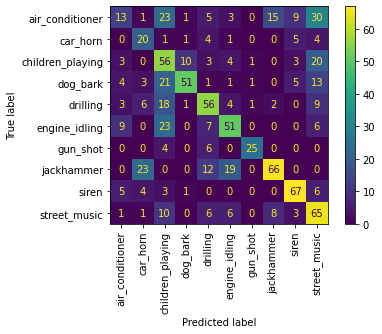

In [385]:
plt.figure(figsize=(9,9))
disp = ConfusionMatrixDisplay(keras_confmat,display_labels=classlabels)
disp.plot(xticks_rotation='vertical')
plt.show()

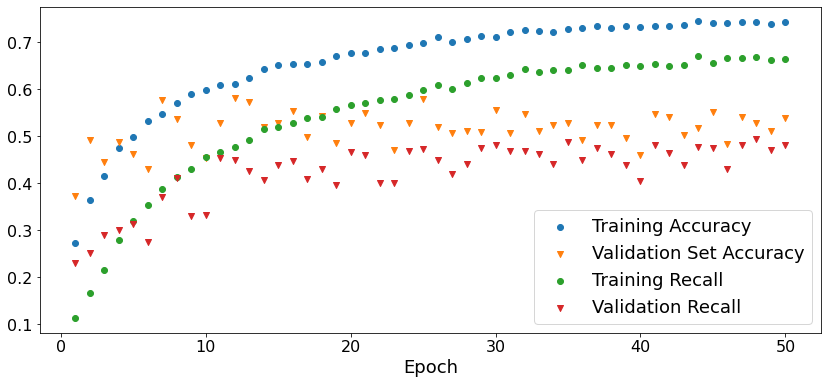

In [386]:
history_dict = history.history

plt.figure(figsize = (14,6))

plt.scatter(range(1,n_epochs+1), history_dict['categorical_accuracy'], label = "Training Accuracy")
plt.scatter(range(1,n_epochs+1), history_dict['val_categorical_accuracy'], marker='v', label = "Validation Set Accuracy")

plt.scatter(range(1,n_epochs+1), history_dict['recall_1'], label = "Training Recall")
plt.scatter(range(1,n_epochs+1), history_dict['val_recall_1'], marker='v', label = "Validation Recall")

plt.xlabel("Epoch", fontsize=18)
#plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

In [371]:
def make_class_scatter_plot(p,ytest,label):
    fig = plt.figure()
    ax0 = fig.add_subplot(111)

    #ax0.scatter(classlabels,TPR(pred,y_test),label='TPR')
    ax0.scatter(classlabels,precision(ytest,p),label='Precision')
    ax0.scatter(classlabels,recall(ytest,p),label='Recall')
    ax0.scatter(classlabels,Fmeasure(ytest,p),label='Fmeasure')

    ax0.tick_params(rotation=90)
    ax0.legend()
    ax0.set_ylim(0,1)
    plt.title(f'Classifier: {label}')
    plt.tight_layout()
    plt.show()
    
def make_family_scatter_plot(p,ytest,label):
    fig = plt.figure()
    ax0 = fig.add_subplot(111)

    #ax0.scatter(classlabels,TPR(pred,y_test),label='TPR')
    ax0.scatter(familylabels,precision(ytest,p),label='Precision')
    ax0.scatter(familylabels,recall(ytest,p),label='Recall')
    ax0.scatter(familylabels,Fmeasure(ytest,p),label='Fmeasure')

    ax0.tick_params(rotation=90)
    ax0.legend()
    ax0.set_ylim(0,1)
    plt.title(f'Classifier: {label}')
    plt.tight_layout()
    plt.show()

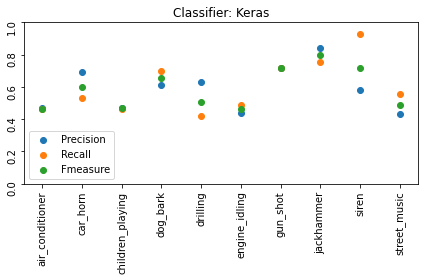

In [372]:
make_class_scatter_plot(y_test,pred_test.argmax(axis=1),'Keras')

In [373]:
recall(pred_test.argmax(axis=1),y_test)[6]

0.7142857142857143

<Figure size 648x648 with 0 Axes>

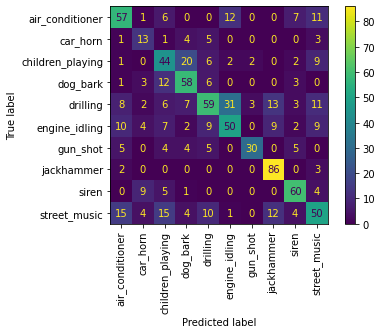

In [357]:
plt.figure(figsize=(9,9))
disp = ConfusionMatrixDisplay(confusion_matrix(pred_mlp,y_test),display_labels=classlabels)
disp.plot(xticks_rotation='vertical')
plt.show()

## Looping through specified models

/home/mheffernan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


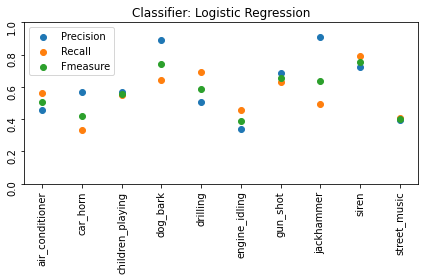

Logistic Regression Classifier accuracy score: 0.561282932416953
Logistic Regression Classifier gunshot recall score: 0.6285714285714286


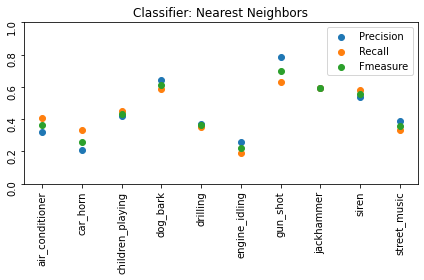

Nearest Neighbors Classifier accuracy score: 0.44215349369988544
Nearest Neighbors Classifier gunshot recall score: 0.6285714285714286


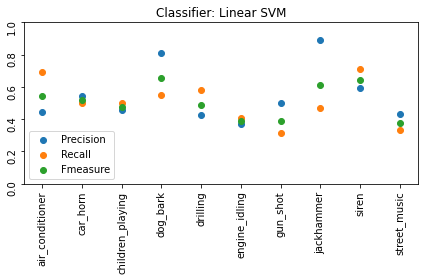

Linear SVM Classifier accuracy score: 0.5154639175257731
Linear SVM Classifier gunshot recall score: 0.3142857142857143


<ipython-input-169-0a88006117b9>:32: RuntimeWarning: invalid value encountered in long_scalars
  prec = lambda a, b, c: a/(b+c)
<ipython-input-170-0037ae515cef>:31: RuntimeWarning: invalid value encountered in long_scalars
  workhorse = lambda a, b, c: a/(b+c)
<ipython-input-170-0037ae515cef>:32: RuntimeWarning: invalid value encountered in double_scalars
  Fmeas = lambda x,y : (2*x*y)/(x+y)


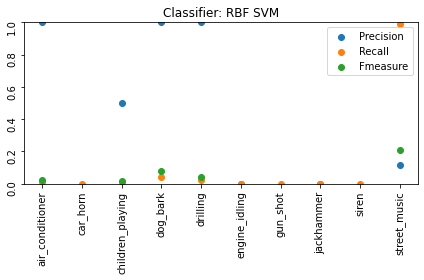

RBF SVM Classifier accuracy score: 0.12256586483390607
RBF SVM Classifier gunshot recall score: 0.0


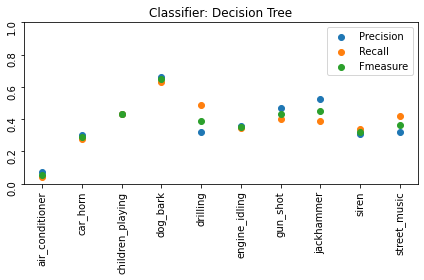

Decision Tree Classifier accuracy score: 0.38258877434135163
Decision Tree Classifier gunshot recall score: 0.4


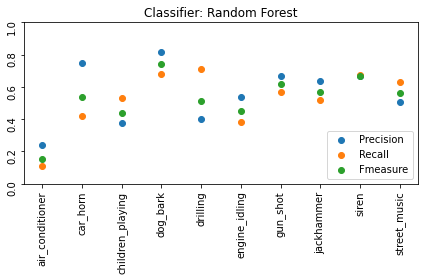

Random Forest Classifier accuracy score: 0.5246277205040092
Random Forest Classifier gunshot recall score: 0.5714285714285714


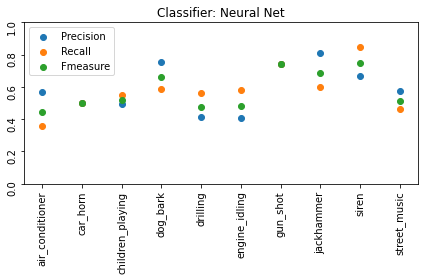

Neural Net Classifier accuracy score: 0.5693012600229095
Neural Net Classifier gunshot recall score: 0.7428571428571429


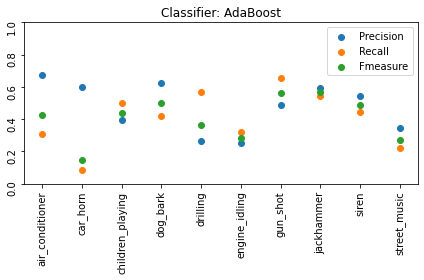

AdaBoost Classifier accuracy score: 0.4146620847651776
AdaBoost Classifier gunshot recall score: 0.6571428571428571


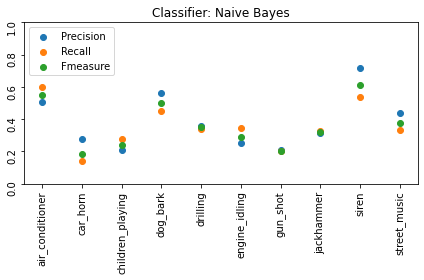

Naive Bayes Classifier accuracy score: 0.37800687285223367
Naive Bayes Classifier gunshot recall score: 0.2


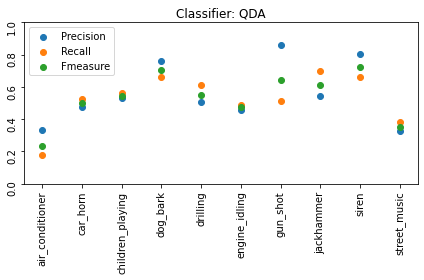

QDA Classifier accuracy score: 0.5315005727376861
QDA Classifier gunshot recall score: 0.5142857142857142


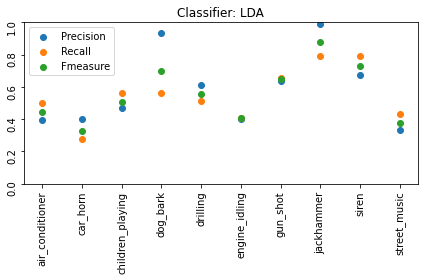

LDA Classifier accuracy score: 0.5624284077892325
LDA Classifier gunshot recall score: 0.6571428571428571


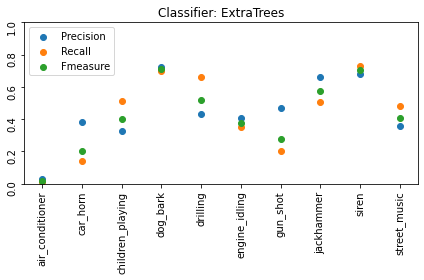

ExtraTrees Classifier accuracy score: 0.4650630011454754
ExtraTrees Classifier gunshot recall score: 0.2


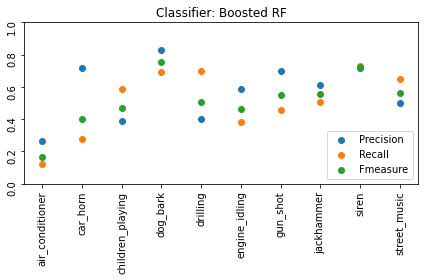

Boosted RF Classifier accuracy score: 0.5292096219931272
Boosted RF Classifier gunshot recall score: 0.45714285714285713


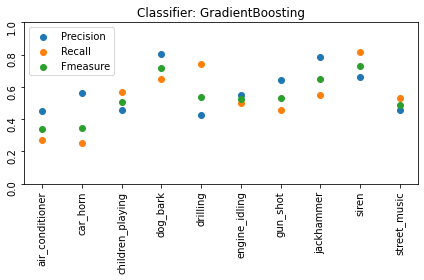

GradientBoosting Classifier accuracy score: 0.5555555555555556
GradientBoosting Classifier gunshot recall score: 0.45714285714285713


In [362]:
for i, classifier in enumerate(classifiers):

    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    make_class_scatter_plot(pred,y_test,names[i])
    print(f'{names[i]} Classifier accuracy score: {accuracy_score(y_test, pred)}')
    print(f'{names[i]} Classifier gunshot recall score: {recall(y_test, pred)[6]}')
#     print(f'{names[i]} Classifier Precision: {precision(y_test, pred)}')
#     print(f'{names[i]} Classifier Recall: {recall(y_test, pred)}')
#     print(f'{names[i]} Classifier Fmeasure: {Fmeasure(y_test, pred)}')
#     print("")

In [50]:
accuracy_score(pred,y_test)

0.5532646048109966

<Figure size 648x648 with 0 Axes>

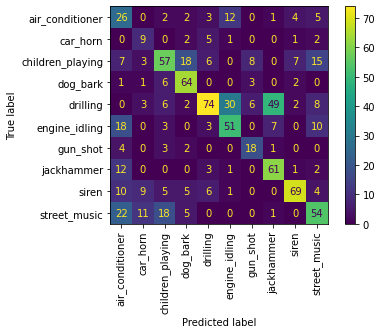

In [51]:
plt.figure(figsize=(9,9))
disp = ConfusionMatrixDisplay(confusion_matrix(pred,y_test),display_labels=classlabels)
disp.plot(xticks_rotation='vertical')
plt.show()

## Trying out a Voting Classifier to beat the others

In [52]:
voter_list = [(names[i], classifiers[i]) for i in range(len(names))]

In [55]:
voting = VotingClassifier(voter_list,
                         voting='hard',
                         n_jobs=4)

In [116]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              Pipeline(steps=[('robustscaler', RobustScaler()),
                                              ('logisticregression',
                                               LogisticRegression(max_iter=5000))])),
                             ('Nearest Neighbors',
                              Pipeline(steps=[('robustscaler', RobustScaler()),
                                              ('kneighborsclassifier',
                                               KNeighborsClassifier(n_jobs=4))])),
                             ('Linear SVM',
                              Pipeline(steps=[('robustscaler', RobustScaler()),
                                              ('s...
                                               LinearDiscriminantAnalysis())])),
                             ('ExtraTrees',
                              Pipeline(steps=[('robustscaler', RobustScaler()),
                                             

In [56]:
vpred = voting.predict(X_test)


NotFittedError: This VotingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [118]:
accuracy_score(y_test,vpred)

0.5624284077892325

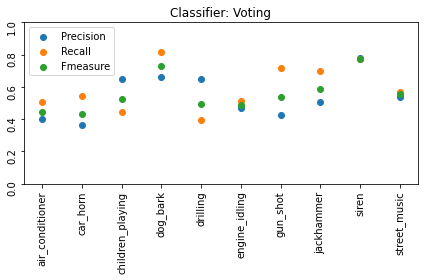

In [119]:
make_class_scatter_plot(vpred,y_test,'Voting')

In [121]:
np.mean(TPR(y_test,vpred))

0.5445835640457735

In [122]:
np.mean(precision(y_test,vpred))

0.5966663700665487

In [123]:
np.mean(recall(y_test,vpred))

0.5445835640457735

In [124]:
np.mean(Fmeasure(y_test,vpred))

0.5570911836496554

Notably, the Voting Classifier doesn't always improve things. 

### What about a stacking classifier?

In [57]:
estimators = [('LDA', make_pipeline(StandardScaler(),LinearDiscriminantAnalysis())),
    ('rf', RandomForestClassifier(max_depth=15,n_estimators=500, random_state=42))
]

In [58]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=5000))

In [59]:
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('svr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('lineardiscriminantanalysis',
                                                 LinearDiscriminantAnalysis())])),
                               ('rf',
                                RandomForestClassifier(max_depth=15,
                                                       n_estimators=500,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(max_iter=5000))

In [60]:
stackpred = clf.predict(X_test)

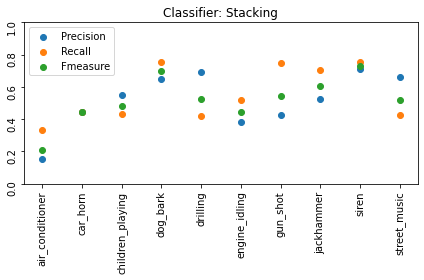

In [61]:
make_class_scatter_plot(stackpred,y_test,'Stacking')

In [62]:
accuracy_score(stackpred,y_test)

0.5292096219931272

## Considering all folds in validation

In [32]:
len(names)

13

In [33]:
accuracies = np.zeros((10, len(names)))
TPRs = np.zeros((10,len(names)))
Fs = np.zeros((10,len(names)))
recalls = np.zeros((10,len(names)))
precisions = np.zeros((10,len(names)))

In [34]:
for dfi in range(0,10):
    dropfold = dfi + 1
    cv_features_df = features_df.drop(features_df[features_df['fold']==dropfold].index)
    validation_features_df = features_df.drop(features_df[features_df['fold']!=dropfold].index)

    if len(classify_keys) == 1:
        X_train = cv_features_df[classify_keys[0]].values.reshape(-1,1)
    else:
        X_train = cv_features_df[classify_keys].values

    y_train = cv_features_df['class'].values

    X_test = validation_features_df[classify_keys].values
    y_test = validation_features_df['class']

    for i, classifier in enumerate(classifiers):
        print(dfi, i)
        classifier.fit(X_train, y_train)
        pred = classifier.predict(X_test)
        
        accuracies[dfi][i] = accuracy_score(y_test, pred)
        TPRs[dfi][i] = TPR(y_test, pred)
        Fs[dfi][i] = Fmeasure(y_test, pred)
        recalls[dfi][i] = recall(y_test, pred)
        precisions[dfi][i] = precision(y_test, pred)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
7 0
7 1
7 2
7 3


<ipython-input-13-bf842f1e60e5>:32: RuntimeWarning: invalid value encountered in double_scalars
  Fmeas = lambda x,y : (2*x*y)/(x+y)


7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12


In [35]:
TPRs_final = np.mean(TPRs,axis=0)
accuracies_final = np.mean(accuracies,axis=0)
Fs_final = np.mean(Fs,axis=0)
recalls_final = np.mean(recalls,axis=0)
precisions_final = np.mean(precisions,axis=0)

In [36]:
for i,name in enumerate(names):
    print(f'{name} accuracy: {accuracies_final[i]}')

Logistic Regression accuracy: 0.5425496112025389
Nearest Neighbors accuracy: 0.4514205223731942
Linear SVM accuracy: 0.4827354771887668
RBF SVM accuracy: 0.39589141480566764
Decision Tree accuracy: 0.4139801900471256
Random Forest accuracy: 0.5421407705422256
Neural Net accuracy: 0.5610780074115181
AdaBoost accuracy: 0.3915390529956718
Naive Bayes accuracy: 0.3234899760812644
QDA accuracy: 0.466816725386908
LDA accuracy: 0.46016797941904547
ExtraTrees accuracy: 0.4909148128133312
Boosted RF accuracy: 0.544672786804426


In [37]:
for i,name in enumerate(names):
    print(f'{name} TPR: {TPRs_final[i]}')

Logistic Regression TPR: 0.5378700435458591
Nearest Neighbors TPR: 0.46048357175783794
Linear SVM TPR: 0.47226842015612247
RBF SVM TPR: 0.3742313724017198
Decision Tree TPR: 0.4245740986076486
Random Forest TPR: 0.5445354276874319
Neural Net TPR: 0.5670828426362703
AdaBoost TPR: 0.39989120926766153
Naive Bayes TPR: 0.3217824543596647
QDA TPR: 0.46828793197839846
LDA TPR: 0.44688797892932197
ExtraTrees TPR: 0.4799060151258794
Boosted RF TPR: 0.5479338566229124


In [38]:
for i,name in enumerate(names):
    print(f'{name} Fmeasure: {Fs_final[i]}')

Logistic Regression Fmeasure: 0.5355785299768603
Nearest Neighbors Fmeasure: 0.45391351784471984
Linear SVM Fmeasure: 0.47217333734270844
RBF SVM Fmeasure: nan
Decision Tree Fmeasure: 0.41428880691418046
Random Forest Fmeasure: 0.5389281492298815
Neural Net Fmeasure: 0.5598119755456575
AdaBoost Fmeasure: 0.3786211682428176
Naive Bayes Fmeasure: 0.30238820847647674
QDA Fmeasure: 0.47298664355691
LDA Fmeasure: 0.45368748461266434
ExtraTrees Fmeasure: 0.47211375219155727
Boosted RF Fmeasure: 0.5423479225584578


In [39]:
for i,name in enumerate(names):
    print(f'{name} recall: {recalls_final[i]}')

Logistic Regression recall: 0.5378700435458591
Nearest Neighbors recall: 0.46048357175783794
Linear SVM recall: 0.47226842015612247
RBF SVM recall: 0.3742313724017198
Decision Tree recall: 0.4245740986076486
Random Forest recall: 0.5445354276874319
Neural Net recall: 0.5670828426362703
AdaBoost recall: 0.39989120926766153
Naive Bayes recall: 0.3217824543596647
QDA recall: 0.46828793197839846
LDA recall: 0.44688797892932197
ExtraTrees recall: 0.4799060151258794
Boosted RF recall: 0.5479338566229124


In [40]:
for i,name in enumerate(names):
    print(f'{name} precision: {precisions_final[i]}')

Logistic Regression precision: 0.5709708848898587
Nearest Neighbors precision: 0.46428290835212965
Linear SVM precision: 0.5355037897732108
RBF SVM precision: 0.4672654970562576
Decision Tree precision: 0.41988513552000245
Random Forest precision: 0.5568981762268274
Neural Net precision: 0.5758761852603016
AdaBoost precision: 0.39299912193524494
Naive Bayes precision: 0.41589962085115967
QDA precision: 0.5241336336337945
LDA precision: 0.5271520612050247
ExtraTrees precision: 0.49774286211331714
Boosted RF precision: 0.5635709060978755


## Now: Tune the best models

Now that a preliminary search of the classifier space has given us a ranking of classifiers, we can focus the search on a more limited number of methods. We can then tune these hyperparameters for optimal performance.

Preliminary model ranking:
   1. Random Forest (Boosted is comparable)
   2. Neural Net
   3. Naive Bayes

# Hierarchical Classification

First, focus on gunshot vs. other noise. Then, once we've accomplished that, we can split it up into other groups after dropping the gunshots.

In [ ]:
class columnTransformer():
    """replace column values for family so I can do two-stage classification
    
    Stolen from: https://stackoverflow.com/questions/68402691/adding-dropping-column-instance-into-a-pipeline
    
    """
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return #X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

In [216]:
if len(classify_keys) == 1:
    Xf_train = cv_features_df[classify_keys[0]].values.reshape(-1,1)
else:
    Xf_train = cv_features_df[classify_keys].values
    
yf_train = cv_features_df['family'].values

Xf_test = validation_features_df[classify_keys].values
yf_test = validation_features_df['family']

if len(classify_keys) == 1:
    Xc_train = cv_features_df[classify_keys[0]].values.reshape(-1,1)
else:
    Xc_train = cv_features_df[classify_keys].values
    
yc_train = cv_features_df['class'].values

Xc_test = validation_features_df[classify_keys].values
yc_test = validation_features_df['class']

In [217]:
# first: gunshot vs no gunshot

In [256]:
base_lr = LogisticRegression(solver='lbfgs', max_iter=5000)
chain = ClassifierChain(base_lr, order='random', random_state=0)

In [226]:
forest = make_pipeline(RobustScaler(), 
                       #RandomForestClassifier(max_depth=15, n_estimators=1000,n_jobs=4),
                       GradientBoostingClassifier(),
                      )

In [227]:
forest.fit(Xf_train,yf_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [257]:
base_lr.fit(Xf_train, yf_train)

LogisticRegression(max_iter=5000)

In [258]:
pred = base_lr.predict(Xf_test)#forest.predict(Xf_test)

In [261]:
accuracy_score(pred,yf_test)

0.97709049255441

In [262]:
precision(pred,yf_test)

[0.9916467780429594, 0.6285714285714286]

In [263]:
recall(pred,yf_test)

[0.9845971563981043, 0.7586206896551724]

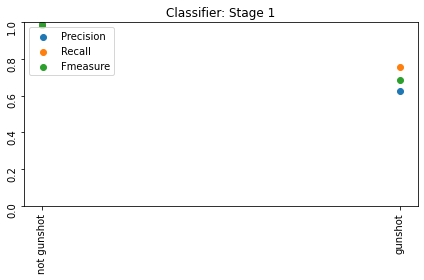

In [259]:
make_family_scatter_plot(pred,yf_test,'Stage 1')

<Figure size 648x648 with 0 Axes>

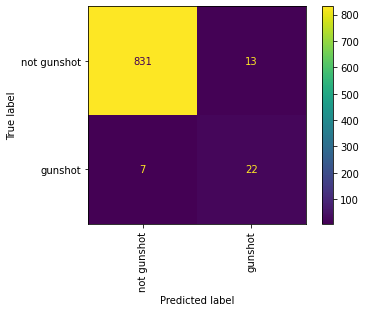

In [260]:
plt.figure(figsize=(9,9))
disp = ConfusionMatrixDisplay(confusion_matrix(pred,yf_test),display_labels=familylabels)
disp.plot(xticks_rotation='vertical')
plt.show()

In [208]:
# second: drop gunshot classes